<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

Mounted at /content/drive


In [2]:
# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'

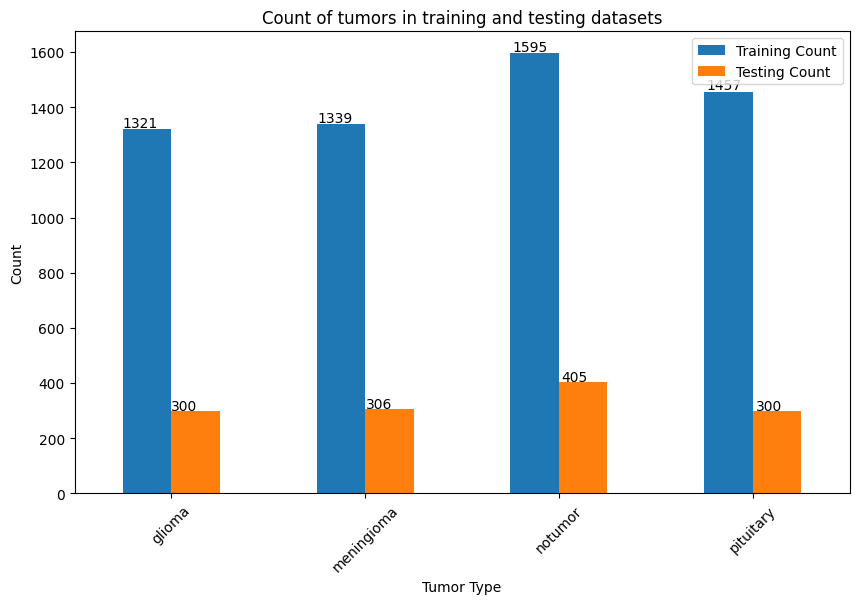

In [3]:
def get_images(directory_path):
    count_image_dict = {}
    img_paths = []
    img_labels = []
    for class_img_dir in os.listdir(directory_path):
        class_img_path = os.path.join(directory_path, class_img_dir)
        if os.path.isdir(class_img_path):
            count_image_dict[class_img_dir] = len(os.listdir(class_img_path))
            for img_name in os.listdir(class_img_path):
                img_paths.append(os.path.join(class_img_path, img_name))
                img_labels.append(class_img_dir)
    return count_image_dict, img_paths, img_labels

training_count, training_img_paths, training_label = get_images(training_path)
testing_count, testing_image_paths, testing_label = get_images(testing_path)

training_data_df = pd.DataFrame(list(training_count.items()), columns=['Tumor Type', 'Training Count'])
testing_data_df = pd.DataFrame(list(testing_count.items()), columns=['Tumor Type', 'Testing Count'])

combined_data_df = pd.merge(training_data_df, testing_data_df, on='Tumor Type')
combined_data_df.set_index('Tumor Type', inplace=True)

axes = combined_data_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of tumors in training and testing datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in axes.patches:
    axes.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [4]:
unique_names = list(set(training_label))
class_naming = {label: idx for idx, label in enumerate(unique_names)}

training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

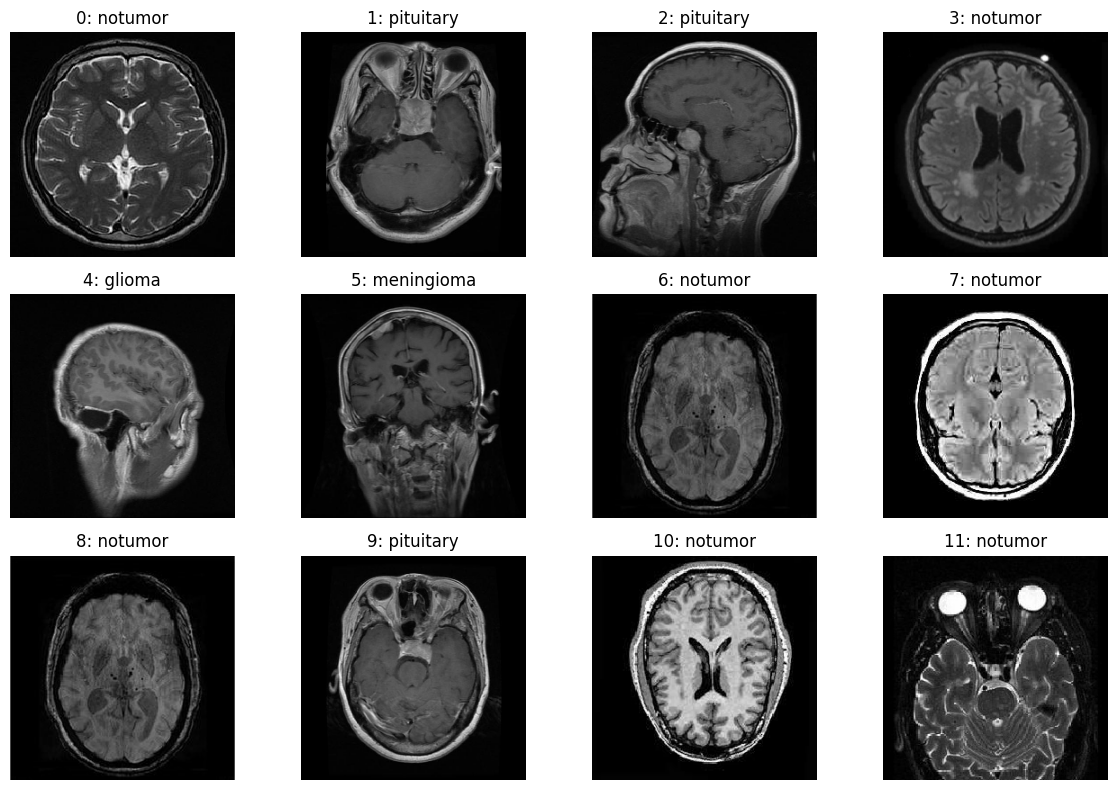

In [5]:
unique_names = list(set(training_label))
class_naming = {label: idx for idx, label in enumerate(unique_names)}

training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

def show_img(path, label_indx, class_naming, index_list=range(10), img_size=250, figsize=(12, 8)):
    num_img = len(index_list)
    rows = (num_img + 3) // 4
    indx_to_class = {v: k for k, v in class_naming.items()}
    _, axes = plt.subplots(nrows=rows, ncols=4, figsize=figsize)
    axes = axes.flatten()

    for i, index in enumerate(index_list):
        if i >= num_img or index >= len(path):
            axes[i].axis('off')
            continue
        image = load_img(path[index], target_size=(img_size, img_size))
        axes[i].imshow(image)
        class_name = indx_to_class[label_indx[index]]
        axes[i].set_title(f'{index}: {class_name}')
        axes[i].axis('off')

    for j in range(num_img, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

combined = list(zip(training_img_paths, training_label_indx))
random.shuffle(combined)
training_img_paths, training_label_indx = zip(*combined)
show_img(training_img_paths, training_label_indx, class_naming, index_list=range(12))

In [6]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

image_dim = (250, 250)
batch_size = 32

In [7]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_dim)
    return image, label

def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

training_img_paths = np.array(training_img_paths)
training_label_indx = np.array(training_label_indx)
testing_img_paths = np.array(testing_image_paths)
testing_label_indx = np.array(testing_label_indx)

train_ds = tf.data.Dataset.from_tensor_slices((training_img_paths, training_label_indx))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_img_paths, testing_label_indx))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_preprocessed = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

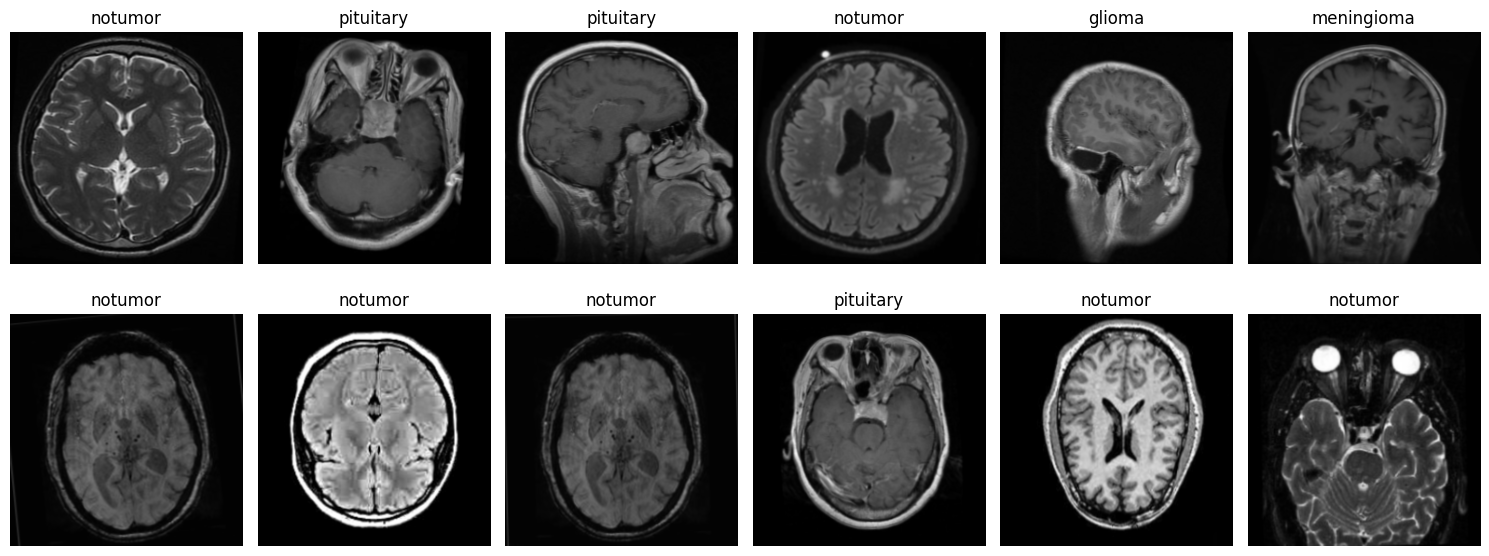

In [8]:
def plot_augmented_images(dataset, shape, class_naming, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    indx_to_class = {v: k for k, v in class_naming.items()}
    for images, label in dataset.take(1):
        for i in range(shape[0] * shape[1]):
            axes = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze())
            plt.title(indx_to_class[label.numpy()[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_naming=class_naming)

In [9]:
num_classes = len(class_naming.keys())
image_shape = (image_dim[0], image_dim[1], 3)
epochs = 50

inv_class_naming = {v: k for k, v in class_naming.items()}
print(f'Inverse class mappings: {inv_class_naming}')

print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
# print(f'Batch size: {batch_size}')


Inverse class mappings: {0: 'meningioma', 1: 'glioma', 2: 'notumor', 3: 'pituitary'}
Number of Classes: 4
Image shape: (250, 250, 3)
Epochs: 50


In [10]:
def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

input_shape = (image_dim[0], image_dim[1], 3)
model = create_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

In [13]:
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

vgg16 only

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


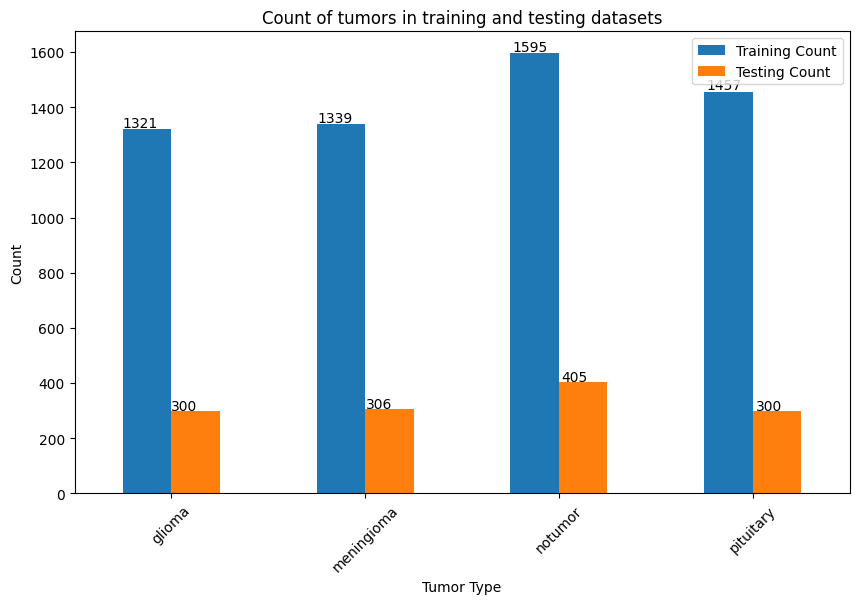

Inverse class mappings: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
Number of Classes: 4
Image shape: (250, 250, 3)
Epochs: 10
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
179/179 [==============================] - 269s 1s/step - loss: 0.4340 - accuracy: 0.8290 - val_loss: 0.3038 - val_accuracy: 0.8894 - lr: 1.0000e-04
Epoch 2/10
179/179 [==============================] - 30s 169ms/step - loss: 0.2002 - accuracy: 0.9298 - val_loss: 0.2047 - val_accuracy: 0.9260 - lr: 1.0000e-04
Epoch 3/10
179/179 [==============================] - 31s 172ms/step - loss: 0.1568 - accuracy: 0.9452 - val_loss: 0.1293 - val_accuracy: 0.9497 - lr: 1.0000e-04
Epoch 4/10
179/179 [==============================] - 31s 172ms/step - loss: 0.1048 - accuracy: 0.9627 - val_loss: 0.0999 - val_accuracy: 0.9634 - lr: 1.0000e-04
Epoch 5/10
179/179 [==============================] - 31s 170ms/step - loss: 0.0586 - accuracy: 0.9792 - val_loss: 0.0666 - val_accuracy: 0.9741 

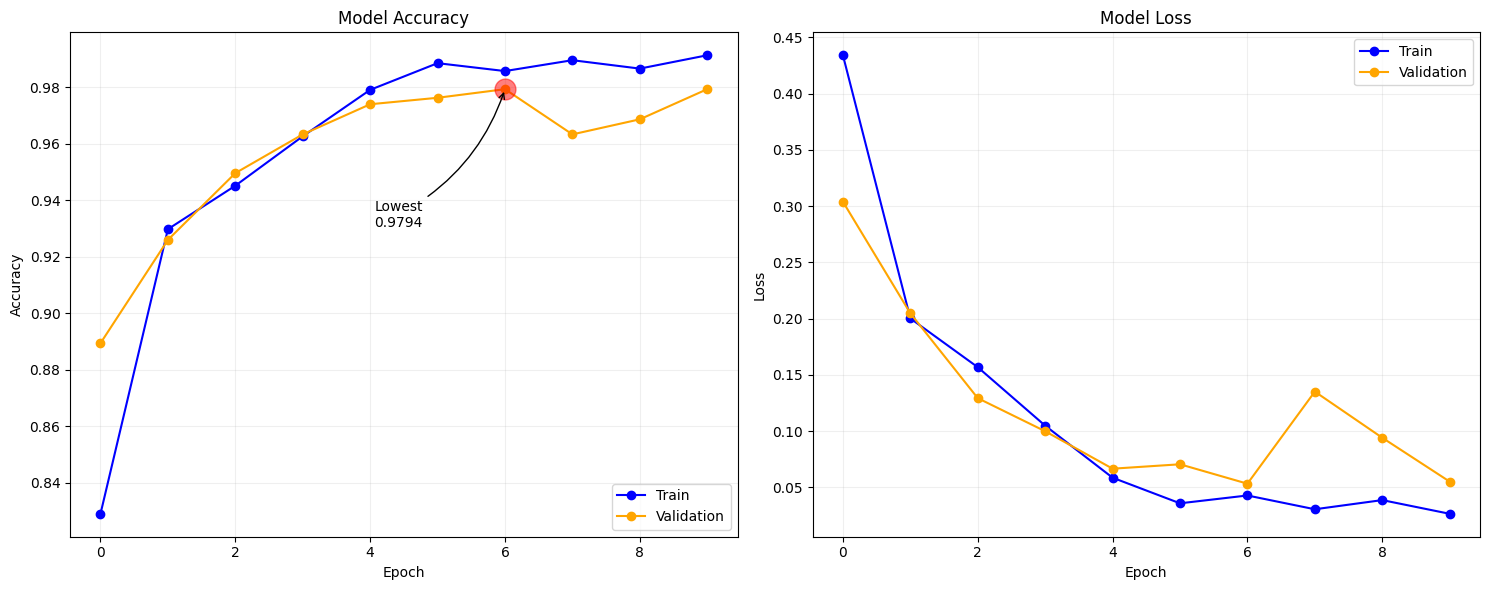

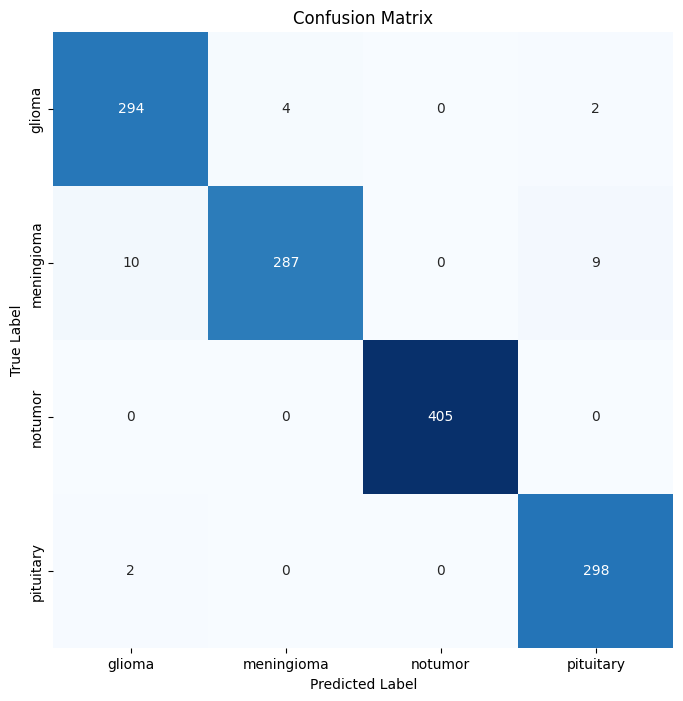

Class-wise metrics:
Class: glioma
Precision: 0.9608
Recall: 0.9800
F1-Score: 0.9703

Class: meningioma
Precision: 0.9863
Recall: 0.9379
F1-Score: 0.9615

Class: notumor
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Class: pituitary
Precision: 0.9644
Recall: 0.9933
F1-Score: 0.9787

Overall Accuracy: 0.9794


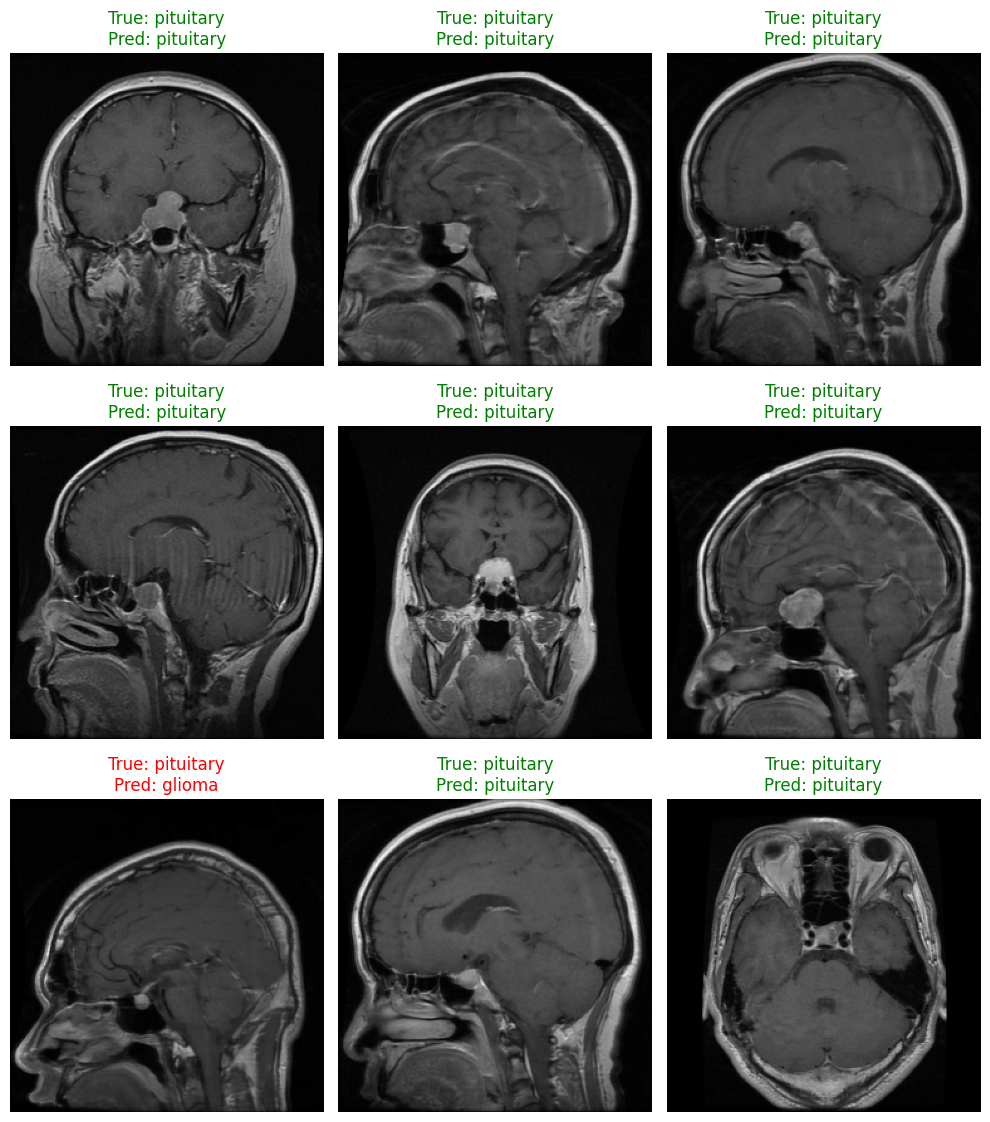

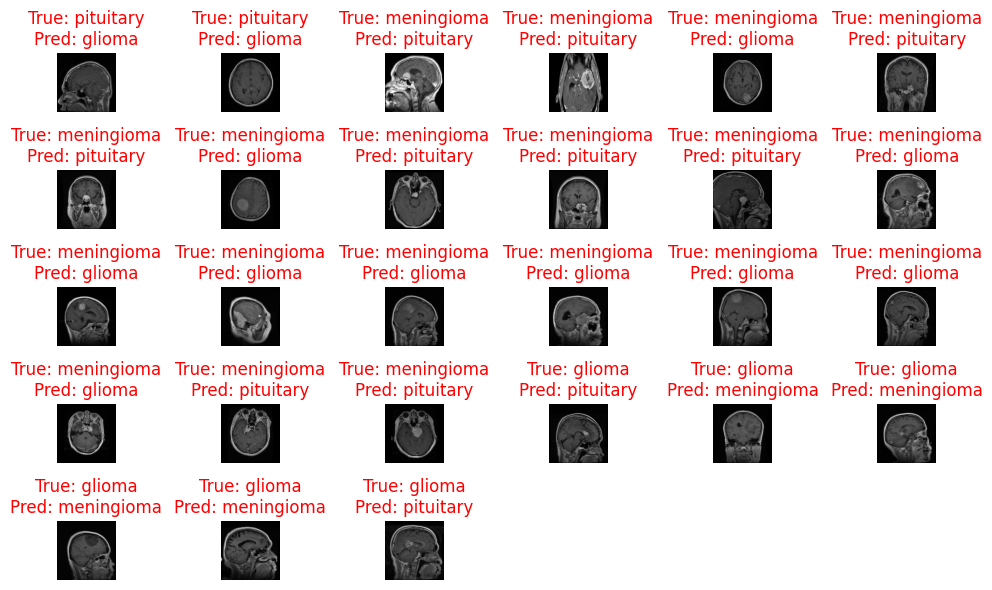

In [3]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'

# Function to get image paths and labels
def get_images(directory_path):
    count_image_dict = {}
    img_paths = []
    img_labels = []
    for class_img_dir in os.listdir(directory_path):
        class_img_path = os.path.join(directory_path, class_img_dir)
        if os.path.isdir(class_img_path):
            count_image_dict[class_img_dir] = len(os.listdir(class_img_path))
            for img_name in os.listdir(class_img_path):
                img_paths.append(os.path.join(class_img_path, img_name))
                img_labels.append(class_img_dir)
    return count_image_dict, img_paths, img_labels

# Get training and testing data
training_count, training_img_paths, training_label = get_images(training_path)
testing_count, testing_image_paths, testing_label = get_images(testing_path)

# Create dataframes for visualization
training_data_df = pd.DataFrame(list(training_count.items()), columns=['Tumor Type', 'Training Count'])
testing_data_df = pd.DataFrame(list(testing_count.items()), columns=['Tumor Type', 'Testing Count'])

combined_data_df = pd.merge(training_data_df, testing_data_df, on='Tumor Type')
combined_data_df.set_index('Tumor Type', inplace=True)

# Plot bar chart for count of tumors
axes = combined_data_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of tumors in training and testing datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in axes.patches:
    axes.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

# Encode labels
unique_names = list(set(training_label))
class_naming = {label: idx for idx, label in enumerate(unique_names)}
training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

# Function to show images
def show_img(path, label_indx, class_naming, index_list=range(10), img_size=250, figsize=(12, 8)):
    num_img = len(index_list)
    rows = (num_img + 3) // 4
    indx_to_class = {v: k for k, v in class_naming.items()}
    _, axes = plt.subplots(nrows=rows, ncols=4, figsize=figsize)
    axes = axes.flatten()

    for i, index in enumerate(index_list):
        if i >= num_img or index >= len(path):
            axes[i].axis('off')
            continue
        image = load_img(path[index], target_size=(img_size, img_size))
        axes[i].imshow(image)
        class_name = indx_to_class[label_indx[index]]
        axes[i].set_title(f'{index}: {class_name}')
        axes[i].axis('off')

    for j in range(num_img, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Shuffle training data
combined = list(zip(training_img_paths, training_label_indx))
random.shuffle(combined)
training_img_paths, training_label_indx = zip(*combined)

# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

image_dim = (250, 250)
batch_size = 32

# Function to load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_dim)
    return image, label

def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

# Convert paths and labels to numpy arrays
training_img_paths = np.array(training_img_paths)
training_label_indx = np.array(training_label_indx)
testing_img_paths = np.array(testing_image_paths)
testing_label_indx = np.array(testing_label_indx)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((training_img_paths, training_label_indx))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_img_paths, testing_label_indx))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_preprocessed = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Function to plot augmented images
def plot_augmented_images(dataset, shape, class_naming, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    indx_to_class = {v: k for k, v in class_naming.items()}
    for images, label in dataset.take(1):
        for i in range(shape[0] * shape[1]):
            axes = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze())
            plt.title(indx_to_class[label.numpy()[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Encode labels
num_classes = len(class_naming.keys())
image_shape = (image_dim[0], image_dim[1], 3)
epochs = 10

inv_class_naming = {v: k for k, v in class_naming.items()}
print(f'Inverse class mappings: {inv_class_naming}')

print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

# Function to create CNN model with VGG16
def create_cnn_vgg16_model(input_shape, num_classes):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    # Freeze all the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    # Unfreeze the last few layers of the base model
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

input_shape = (image_dim[0], image_dim[1], 3)
model = create_cnn_vgg16_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Custom callback for reducing learning rate based on accuracy thresholds
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

thresholds = [0.96, 0.99, 0.9935]
model_file = '/content/drive/MyDrive/Final project/cnn_vgg16_model.keras'
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint(model_file, monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Train the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)

# Load the best model
model = load_model(model_file)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")

# Plot training and validation accuracy/loss
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

axes[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

axes[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

# Using test data for true and predictions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=False, cmap='Blues'):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), va='center')
    plt.show()

    if metrics:
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_naming)):
            class_name = list(class_naming.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

# Plot confusion matrix and metrics
plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=True)

# Function to plot sample predictions
def plot_sample_predictions(model, dataset, indx_to_class, num_samples=9, figsize=(13, 12)):
    plt.figure(figsize=figsize)
    rows = num_cols = int(np.sqrt(num_samples))

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = indx_to_class[true_class_index]
        predicted_class = indx_to_class[predicted_label]

        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plotting samples with predictions
plot_sample_predictions(model=model, dataset=test_ds_preprocessed, indx_to_class=inv_class_naming, num_samples=9, figsize=(10, 11.5))

# Function to plot misclassified samples
def plot_misclassified_samples(model, dataset, indx_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(indx_to_class[true_class_index])
            misclassified_predictions.append(indx_to_class[predicted_label])

    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plotting misclassified samples
plot_misclassified_samples(model=model, dataset=test_ds_preprocessed, indx_to_class=inv_class_naming, figsize=(10, 6))
